# 1 Introducción

En el siguiente cuaderno se realizara el código del algoritmo de Box Blur, el cual trata de un filtro en el que cada pixel de la imagen resultante tiene un valor igual al promedio de los pixeles que lo rodean (incluyendo al mismo pixel), provocando el desenfoque. Por ejemplo:
 Dado     <center>7 4 0</center>
     <center> 5 **6** 2</center>
     <center> 6 10 7</center>
     
La imagen resultante es: (7+4+0+5+6+2+6+10+7)/ 9 = 5.22 = 5

Teniendo en cuenta que cada pixel cuanta con 3 canales de colores (rojo, verde y azul) se debera repetir lo anterior dicho en cada canal y guardar el resultado del promedio en el canal correspondiente de la imagen resultado.

---
# 2 Armado del ambiente

In [3]:
#@title ## 0.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://cdn-codespeedy.pressidium.com/wp-content/uploads/2019/12/test.jpg" #@param {type:"string"}

#@markdown ---

!wget {url_imagen} -O imagen.jpg


--2021-07-03 22:13:14--  https://cdn-codespeedy.pressidium.com/wp-content/uploads/2019/12/test.jpg
Resolving cdn-codespeedy.pressidium.com (cdn-codespeedy.pressidium.com)... 23.111.9.67
Connecting to cdn-codespeedy.pressidium.com (cdn-codespeedy.pressidium.com)|23.111.9.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg              [ <=>                ] 143.34K  --.-KB/s    in 0.007s  

2021-07-03 22:13:14 (19.5 MB/s) - ‘imagen.jpg’ saved [146780]



---
## 2.2 Instalacion en el cuaderno del módulo CUDA de Python.

In [4]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 36.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=43a9b6c9ba728d5728be6d7d80b80d7f1c5933e5b1095f6bce463113ce8f78bf
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=46ea7e646ea2cfb08c7511dc53577d78997575b1b34d503863bfdcaa654bf687
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


---
# 3 Desarrollo CPU

Tiempo de conversión de imagen: 4084.887 [ms]
Tiempo Total: 4153.517 [ms]
Detalles: RGB- [555, 368]


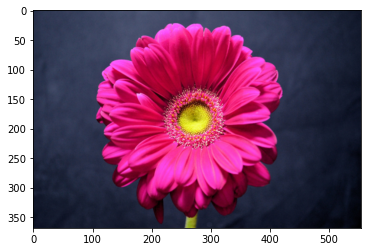

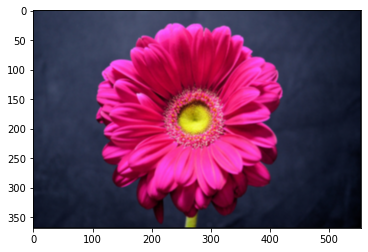

In [5]:
%matplotlib inline

from datetime import datetime
tiempo_total = datetime.now()

import  matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
import sys

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

try:
    
    img_nombre = str('imagen.jpg')
    image = Image.open(img_nombre)

    # Optengo las proporsiones de la imagen. 
    img_ancho, img_alto = image.size 

    # Convierto la imagen comprimida en JPEG/PNG a array.
    img_pic_cpu = np.asarray(image)
    img_pic_cpu = img_pic_cpu.astype( np.int32() )

    # Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
    img_picR_cpu = np.empty_like( img_pic_cpu )

except FileNotFoundError:
    sys.exit("Cannot load image file")

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

sum = 0

for channel in (0,1,2):
  for y in range(1, img_ancho - 1):
    for x in range(1, img_alto - 1):
      sum+= img_pic_cpu[x, y, channel]
      sum+= img_pic_cpu[x - 1, y - 1, channel]
      sum+= img_pic_cpu[x - 1, y, channel]
      sum+= img_pic_cpu[x - 1, y + 1, channel]
      sum+= img_pic_cpu[x, y - 1, channel]
      sum+= img_pic_cpu[x, y + 1, channel]
      sum+= img_pic_cpu[x + 1, y - 1, channel]
      sum+= img_pic_cpu[x + 1, y, channel]
      sum+= img_pic_cpu[x + 1, y + 1, channel]
      img_picR_cpu[x,y,channel] = sum // 9
      sum = 0

# end time
tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# Muestro los atributos de las imagenes
print("Detalles: " + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )


---
# 4 Desarrollo GPU

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Detalles: RGB- [925, 500]
Tiempo TOTAL:  64.663 [ms]
Tiempo GPU  :  0.217 [ms]


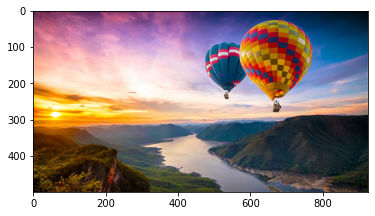

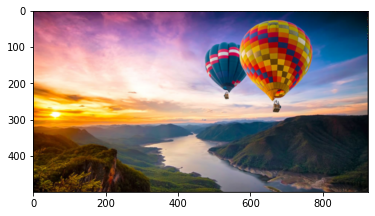

In [ ]:
%matplotlib inline

from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import sys

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

try:

    img_nombre = str('imagen.jpg')
    image = Image.open(img_nombre)

    # Optengo las proporsiones de la imagen. 
    img_ancho, img_alto = image.size 

    # Convierto la imagen comprimida en JPEG/PNG a array
    img_O_cpu = np.asarray(image)
    img_O_cpu = img_O_cpu.astype( np.int32() )
    img_R_cpu = np.empty_like( img_O_cpu)

    # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
    img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
    img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

    # GPU - Copio la memoria al GPU.
    cuda.memcpy_htod( img_O_gpu, img_O_cpu )
    cuda.memcpy_htod( img_R_gpu, img_R_cpu )

except FileNotFoundError:
    sys.exit("Cannot load image file")

dim_hilo_x = 16
dim_bloque_x = np.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = np.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# load CUDA code
module = SourceModule("""
__global__ void applyFilter( int ancho, int alto, int *img_O, int *img_R, int channel)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  int sum = 0;
  int prom = 0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx >= 1 && idx < ancho-1 && idy >= 1 && idy < alto-1 )
  {
         sum += img_O[ ((idx + (idy * ancho)) * 3) + channel ];                  // Actual
         sum += img_O[ (((idx - 1) + ( (idy - 1) * ancho)) * 3) + channel ];     // Arriba izquierda
         sum += img_O[ ((idx + ( (idy-1) * ancho)) * 3) + channel];              // Arriba
         sum += img_O[ (((idx+1) + ((idy-1) * ancho)) * 3) + channel];           // Arriba derecha
         sum += img_O[ (((idx-1) + (idy * ancho)) * 3) + channel];               // Izquierda
         sum += img_O[ (((idx+1) + (idy * ancho)) * 3) + channel];               // Derecha
         sum += img_O[ (((idx-1) + ((idy+1) * ancho)) * 3) + channel];           // Abajo izquierda
         sum += img_O[ ((idx + ((idy+1) * ancho)) * 3) + channel];               // Abajo
         sum += img_O[ (((idx+1) + ((idy+1) * ancho)) * 3) + channel];           // Abajo derecha

         prom = sum / 9;

         img_R[ ((idx + ( idy * ancho )) * 3 ) + channel] = prom;

         sum = 0;
         prom = 0;
  }
}
""")

kernel = module.get_function('applyFilter')

tiempo_img = datetime.now()

for channel in (0, 1, 2):
    kernel( np.int32(img_ancho), np.int32(img_ancho), img_O_gpu, img_R_gpu, np.int32(channel), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Detalles: " + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )


---
# 5 Metricas

El proximo cuadro expresa la relacion entre los tiempos de procesamiento entre la solucion secuencial (CPU) y la solucion paralela (GPU) para distintas dimensiones de imagenes

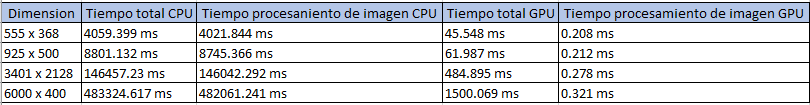

---
# 6 Conclusiones

Con la resolucion de este ejercicio mediante los enfoques de procesamiento secuencial (CPU) y paralelo usando la GPU queda en evidencia la diferencia en tiempo de ambas soluciones.

Se pone en evidencia que a menor sea las dimensiones de las imagenes usadas los tiempos obtenidos de ambas soluciones se asemejan y hasta la solucion paralela llega a ser peor en cuestion de tiempos. Por el contrario a mayor sea las dimensiones de las imagenes los tiempo obtenidos en la solucion paralela son abismalmente mejores que los tiempos de la solucion secuencial.

Como cierre se puede concluir que el beneficio de los multiples cores de un GPU se pone en evidencia cuando el numero de datos de entrada es grande (en este caso pixeles).

---
# 7 Bibliografia

**<< Toda referencia utilizada para confeccionar el ejercicio (incluyendo
el código si tomaron la idea de otro lado) >>**